In [1]:
import util
import graficos
import func

In [2]:
import pandas as pd
import numpy as np
from io import StringIO
import astroquery
from astroquery.sdss import SDSS
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.integrate import quad
import kcorrect.kcorrect

### Primera mirada de la data

In [3]:
data = pd.read_csv('Tabla_Query_Completo.csv')

flags_photo_data = pd.read_csv('flags_photo.csv')
sciencePrimary = pd.read_csv('sciencePrimary.csv')
redshift = pd.read_csv('z.csv')
flujos = pd.read_csv('flujos.csv')

data['flags_photo'] = flags_photo_data['flags']
data['sciencePrimary'] = sciencePrimary['sciencePrimary']
data['z'], data['zErr'] = redshift['z'], redshift['zErr']

#Flujos para correcciones
data['petroFlux_u'], data['petroFlux_g'], data['petroFlux_r'], data['petroFlux_i'], data['petroFlux_z'], data['petroFluxIvar_u'], data['petroFluxIvar_g'], data['petroFluxIvar_r'], data['petroFluxIvar_i'], data['petroFluxIvar_z'],data['modelFlux_u'], data['modelFlux_g'], data['modelFlux_r'], data['modelFlux_i'], data['modelFlux_z'],data['modelFluxIvar_u'], data['modelFluxIvar_g'], data['modelFluxIvar_r'], data['modelFluxIvar_i'], data['modelFluxIvar_z'] = flujos['petroFlux_u'], flujos['petroFlux_g'], flujos['petroFlux_r'], flujos['petroFlux_i'], flujos['petroFlux_z'], flujos['petroFluxIvar_u'], flujos['petroFluxIvar_g'], flujos['petroFluxIvar_r'], flujos['petroFluxIvar_i'], flujos['petroFluxIvar_z'],flujos['modelFlux_u'], flujos['modelFlux_g'], flujos['modelFlux_r'], flujos['modelFlux_i'], flujos['modelFlux_z'],flujos['modelFluxIvar_u'], flujos['modelFluxIvar_g'], flujos['modelFluxIvar_r'], flujos['modelFluxIvar_i'], flujos['modelFluxIvar_z']

data

,targetObjId,specObjId,plateID,targetType,platerun,mjd,fiberId,plate,tile,ra,dec,subClass,rChi2,velDispZ,velDispErr,velDisp,snMedian,snMedian_u,snMedian_g,snMedian_i,snMedian_r,snMedian_z,err_u,err_g,err_r,err_i,err_z,dered_u,dered_g,dered_r,dered_i,dered_z,flags_photo,sciencePrimary,z,zErr,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroFluxIvar_u,petroFluxIvar_g,petroFluxIvar_r,petroFluxIvar_i,petroFluxIvar_z,modelFlux_u,modelFlux_g,modelFlux_r,modelFlux_i,modelFlux_z,modelFluxIvar_u,modelFluxIvar_g,modelFluxIvar_r,modelFluxIvar_i,modelFluxIvar_z
0,1237662225681351109,4476786201135962112,4476578118564327424,SCIENCE,2010.03.c.boss,55302,757,3976,10238,194.65729,40.043862,NaN,0.969012,0,36.94303,223.5089,2.402994,0.277263,1.068178,5.949300,2.890924,5.703272,0.754664,0.154831,0.054332,0.034027,0.072095,26.02415,22.16195,20.56898,19.51054,19.04611,35253360132400,1,0.003652,0.000011,1.265975,0.564709,2.769522,9.249715,13.96307,3.355655,11.078380,5.005302,0.882708,0.273468,0.111379,0.532724,2.540968,7.765737,11.08013,21.060580,83.32870,39.256240,17.717750,1.348413
1,1237662225681416299,4476796646496425984,4476578118564327424,SCIENCE,2010.03.c.boss,55302,795,3976,10238,194.89310,40.018967,NaN,0.895048,0,42.51202,168.4301,2.146727,0.188408,1.012563,4.878816,2.426820,4.522596,0.798556,0.215214,0.061980,0.041441,0.092174,25.67659,22.70170,20.85398,19.89582,19.48770,35253360136464,1,0.038826,0.000022,1.520997,7.279000,17.255610,27.431530,41.17094,1.005604,4.890453,3.581277,0.919326,0.069339,1.263369,6.881178,17.792030,28.511760,38.45181,6.383675,22.48149,9.500206,4.219149,0.376378
2,1237662225681416482,4476794997228984320,4476578118564327424,SCIENCE,2010.03.c.boss,55302,789,3976,10238,194.94416,40.066251,NaN,0.867760,0,35.98687,276.4497,2.201894,0.020968,1.021541,6.238125,2.339731,6.013060,1.865094,0.361760,0.070682,0.039569,0.085155,25.00750,22.73494,20.50344,19.34389,18.86256,35253393555472,1,0.506140,0.000222,-0.060577,1.123501,6.163854,17.892240,28.55483,0.770470,3.577018,0.675381,0.133067,0.047043,-0.108004,1.090114,6.040873,16.440440,24.79734,9.903525,44.70155,16.499390,6.683410,0.564297
3,1237662225681416526,4476784551868520448,4476578118564327424,SCIENCE,2010.03.c.boss,55302,751,3976,10238,194.78395,40.159573,NaN,0.933466,0,114.35870,521.2803,1.742241,0.039070,0.739256,4.296263,1.930853,4.182355,1.297495,0.181978,0.061864,0.047114,0.097615,25.40959,22.23259,20.59428,19.73020,19.15966,68988043520,1,0.502930,0.000134,0.195059,2.899076,13.405770,27.661500,43.01011,1.462771,6.729625,2.588584,1.012463,0.092049,0.553865,2.560638,14.639330,30.320680,47.01673,7.726242,33.49184,11.114450,4.588891,0.417241
4,11275493895700616,1618051533021145088,1617918217236277248,SCIENCE,dr2003.07.3,53046,485,1437,1032,166.44223,41.077492,AGN,1.441620,0,13.52537,105.7042,10.675980,1.835768,6.170340,17.779620,14.246890,11.559420,0.057688,0.008711,0.007165,0.006743,0.019052,19.54494,18.27575,17.52192,17.11875,16.83299,35255507615760,1,0.456967,0.000103,8.275356,27.193290,53.203420,77.069440,89.02147,0.862458,4.019497,1.735270,0.796147,0.061641,8.097833,27.787260,53.842090,80.254250,100.67880,3.563776,10.80624,4.868753,2.298158,0.232303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617795,1237662225681285469,4476773281874335744,4476578118564327424,SCIENCE,2010.03.c.boss,55302,710,3976,10238,194.40414,40.193105,NaN,0.874354,0,35.33378,218.6448,2.718103,0.106824,0.975838,6.790564,3.369422,6.243815,0.963828,0.151748,0.041054,0.031020,0.065289,25.52803,22.40384,20.48546,19.65963,19.18694,105622105362704,1,0.082148,0.000017,1.505520,0.623608,3.544508,8.721571,19.17650,1.069337,9.625391,3.134221,0.707441,0.097563,0.430684,0.952538,3.636879,8.945898,14.13908,6.190253,62.21555,15.910930,6.215899,0.578405
2617796,1237662225681350805,4476783177478985728,447657811856432

In [4]:
data.columns

Index(['targetObjId', 'specObjId', 'plateID', 'targetType', 'platerun', 'mjd',
       'fiberId', 'plate', 'tile', 'ra', 'dec', 'subClass', 'rChi2',
       'velDispZ', 'velDispErr', 'velDisp', 'snMedian', 'snMedian_u',
       'snMedian_g', 'snMedian_i', 'snMedian_r', 'snMedian_z', 'err_u',
       'err_g', 'err_r', 'err_i', 'err_z', 'dered_u', 'dered_g', 'dered_r',
       'dered_i', 'dered_z', 'flags_photo', 'sciencePrimary', 'z', 'zErr',
       'petroFlux_u', 'petroFlux_g', 'petroFlux_r', 'petroFlux_i',
       'petroFlux_z', 'petroFluxIvar_u', 'petroFluxIvar_g', 'petroFluxIvar_r',
       'petroFluxIvar_i', 'petroFluxIvar_z', 'modelFlux_u', 'modelFlux_g',
       'modelFlux_r', 'modelFlux_i', 'modelFlux_z', 'modelFluxIvar_u',
       'modelFluxIvar_g', 'modelFluxIvar_r', 'modelFluxIvar_i',
       'modelFluxIvar_z'],
      dtype='object')

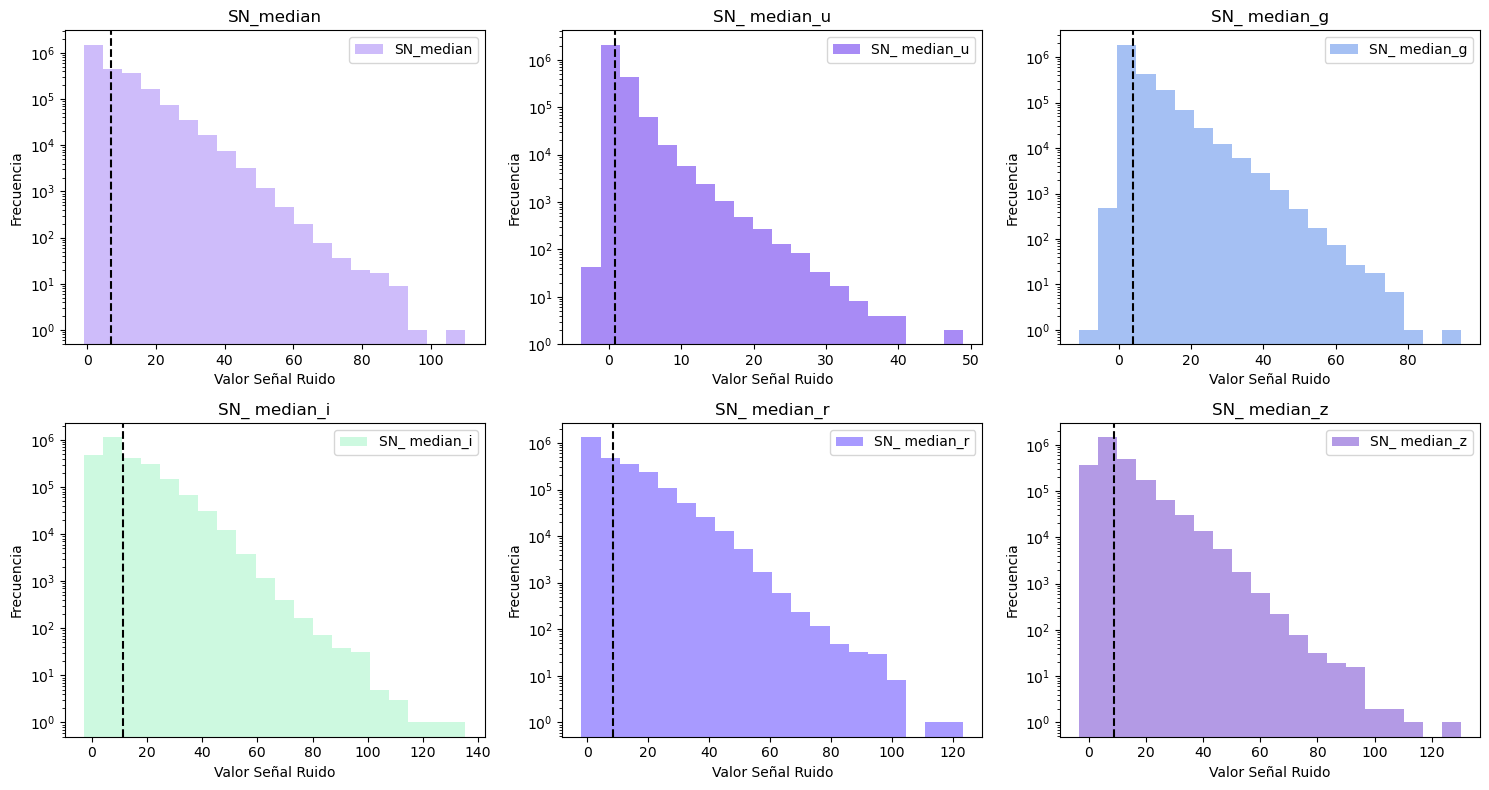

In [6]:
hist_data = [data['snMedian'], data['snMedian_u'], data['snMedian_g'], data['snMedian_i'], data['snMedian_r'], data['snMedian_z']]
colors = ['#BAA0F9', '#835AF1', '#7FA6EE', '#B8F7D4','#8470FF', '#9370DB']
group_labels = ['SN_median', 'SN_ median_u', 'SN_ median_g', 'SN_ median_i', 'SN_ median_r', 'SN_ median_z']

pruebas_init.hist_SN(data, hist_data, group_labels, colors)

# 

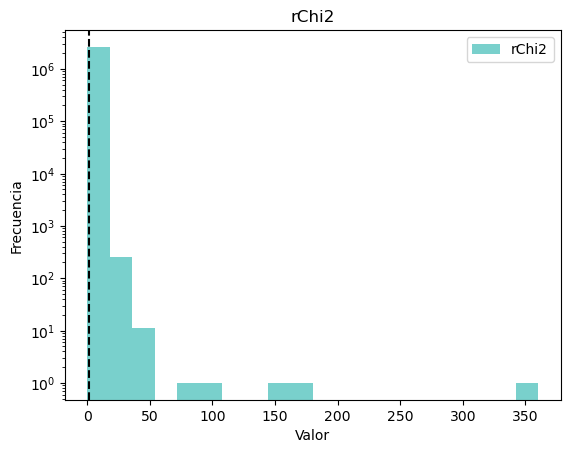

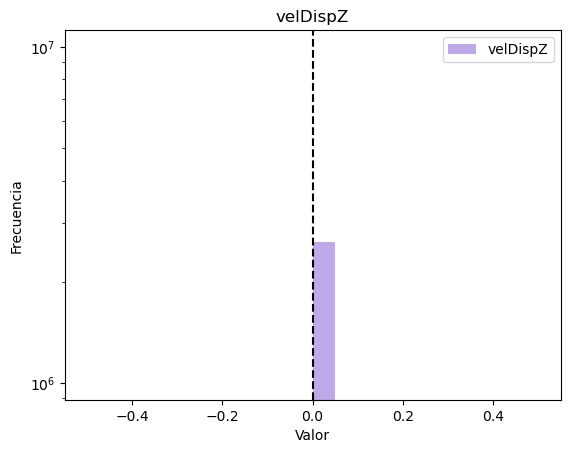

In [7]:
### Chi cuadrado y Dispersion de velocidades
pruebas_init.hist(data['rChi2'], 'lightseagreen', 'rChi2')
pruebas_init.hist(data['velDispZ'], '#9370DB', 'velDispZ')


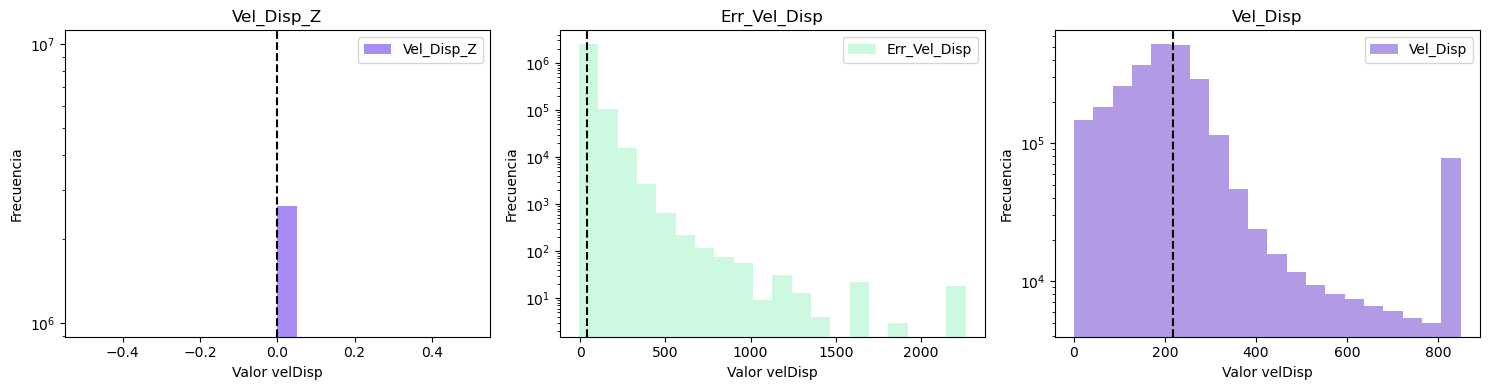

In [8]:
hist_data = [data['velDispZ'], data['velDispErr'], data['velDisp']]
colors = ['#835AF1','#B8F7D4','#9370DB']
group_labels = ['Vel_Disp_Z', 'Err_Vel_Disp', 'Vel_Disp']

pruebas_init.hist_velDisp(data, hist_data, group_labels, colors)

### Limpieza

In [5]:
### Verificar que sean SciencePrimary ###

data['sciencePrimary'].unique()

array([1])

In [6]:
#### drop de los valores -9999.0 ####

data.replace(-9999.0, np.nan, inplace=True)

In [7]:
## Conteo valores NULL ####

acum_g = 0
acum_u = 0

nulos_g = data['dered_g'].isnull()
for i in range(len(data['dered_g'])):
    if nulos_g[i] == True:
        acum_g += 1

nulos_u = data['dered_u'].isnull()
for i in range(len(data['dered_u'])):
    if nulos_u[i] == True:
        acum_u += 1

nulos_r = data['dered_r'].isnull()
for i in range(len(data['dered_r'])):
    if nulos_r[i] == True:
        acum_g += 1
acum_g, acum_u

(121, 70)

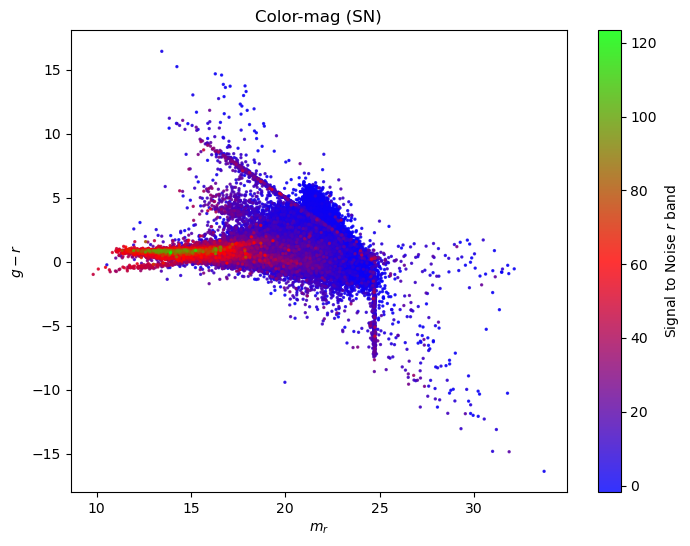

In [8]:
#Limpiando filas de NaNs para estas columnas solamente

data_clean = data.dropna(subset=['dered_r', 'dered_g', 'snMedian_r'])
#len(data_clean)

color = data_clean['dered_g'] - data_clean['dered_r']
#color = data_clean['dered_u'] - data_clean['dered_r']

#Grafico inicial color-mag con densidades respecto a SN 

graficos.color_mag_SN(data_clean, color, 'r')

(array([1.500000e+01, 6.510000e+02, 2.460800e+04, 4.528680e+05,
        5.341360e+05, 1.337182e+06, 2.622850e+05, 5.881000e+03,
        7.700000e+01, 2.900000e+01]),
 array([ 8.826988 , 11.1644382, 13.5018884, 15.8393386, 18.1767888,
        20.514239 , 22.8516892, 25.1891394, 27.5265896, 29.8640398,
        32.20149  ]),
 <BarContainer object of 10 artists>)

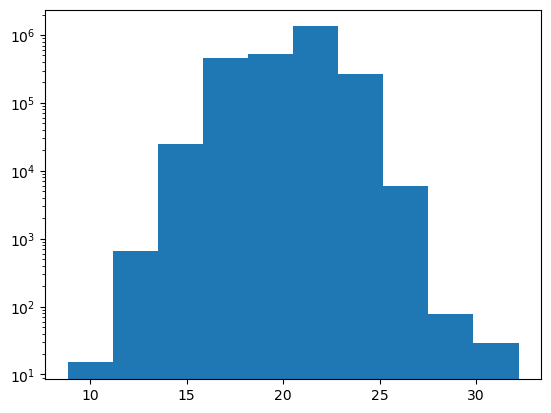

In [9]:
#plt.hist(data['dered_g']-data['dered_r'])
plt.yscale('log')
plt.hist(data['dered_g']) #-data['dered_r'])

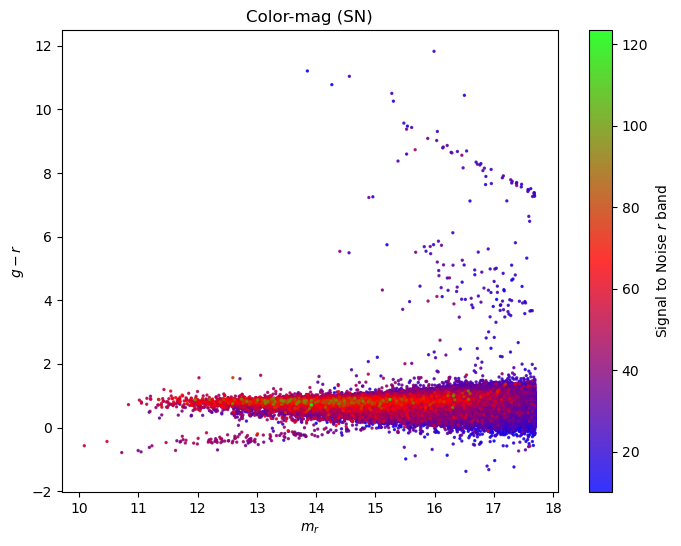

In [10]:
### Restriccion SN > 10  y MAGNITUD LÍMITE###

columnas_a_filtrar = ['snMedian_r', 'snMedian_g']

condicion = pd.Series(False, index=data.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (data[columna] < 10)

data_SN10 = data.loc[condicion]

datos_SN10 = data.drop(data_SN10.index)

data_clean_SN10 = datos_SN10.dropna(subset=['dered_r', 'dered_g', 'snMedian_r'])

## Restricción redshift

condicion_z = condicion | (data_clean_SN10['z'] > 0.05) 

data_sinMagLim = data_clean_SN10.loc[condicion_z] #Data frame limpio pero sin restriccion magnitud limite


## Restriccion Magnitud Límite 

condicion_mag_lim = condicion| (data_clean_SN10['dered_r'] < 17.7) 

data_clean_SN10 = data_sinMagLim.loc[condicion_mag_lim]


color = data_clean_SN10['dered_g'] - data_clean_SN10['dered_r']


graficos.color_mag_SN(data_clean_SN10, color, 'r')

### Identificación de regiones anómalas

In [11]:
#Columna para las etiquetas por regiones
data_clean_SN10['etiqueta'] = 0

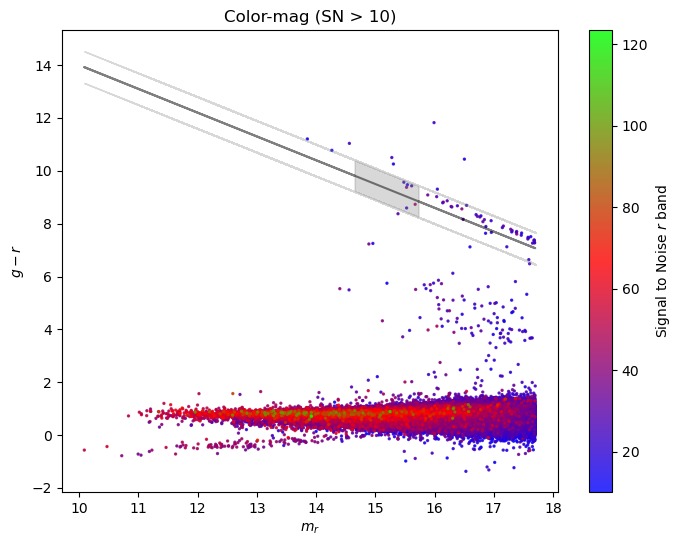

In [12]:
#Region diagonal
graficos.color_mag_SN(data_clean_SN10, color, 'r')

b_diagonal = -0.9*data_clean_SN10['dered_r'] +23
lim_sup = b_diagonal + 0.6
lim_inf = b_diagonal - 0.6

plt.title('Color-mag (SN > 10)')

plt.plot(data_clean_SN10['dered_r'], b_diagonal, color='black', alpha=0.5, label='b_diagonal')
plt.fill_between(data_clean_SN10['dered_r'], lim_sup, lim_inf, color='gray', alpha=0.3, label='Shadowed Path')

plt.show()

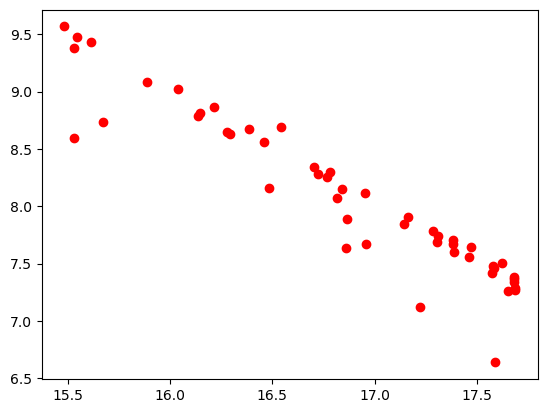

In [13]:
puntos_diagonal = (color <= lim_sup) & (color >= lim_inf) #Puntos dentro de la region delimitada por las rectas diagonales

plt.scatter(data_clean_SN10['dered_r'][puntos_diagonal], color[puntos_diagonal], c='red', label='Points Inside')

#Asignar valor de 1 a la etiqueta de esta zona
data_clean_SN10.loc[puntos_diagonal, 'etiqueta'] = 1

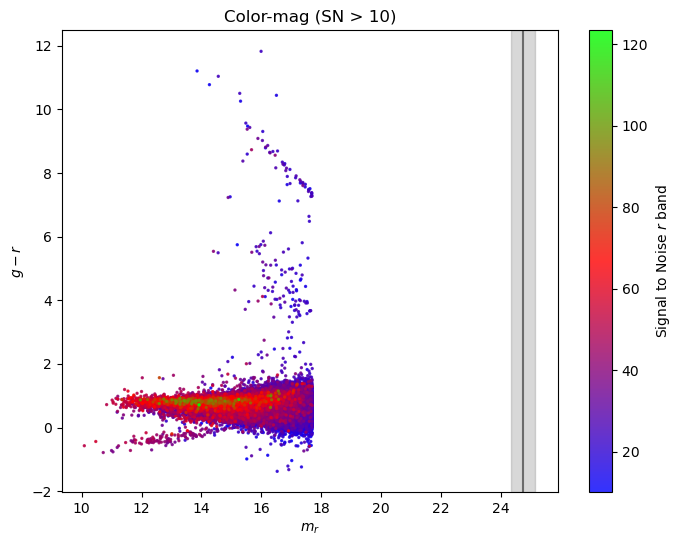

In [14]:
#Region vertical (si no se hace corte por mag limite)
graficos.color_mag_SN(data_clean_SN10, color, 'r')
plt.title('Color-mag (SN > 10)')

plt.axvline(24.75, color='black', linestyle='-', alpha=0.5)
plt.axvspan(24.75 - 0.4, 24.75 + 0.4, color='gray', alpha=0.3)

plt.show()

(10.0, 30.0)

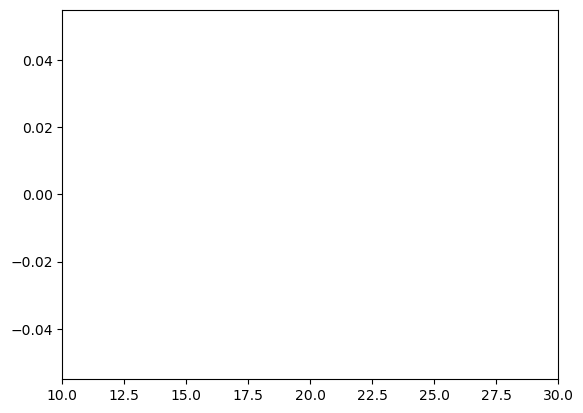

In [15]:
linea_vertical = 24.75

x_range = 0.4 

puntos_vertical = (data_clean_SN10['dered_r'] >= linea_vertical - x_range) & (data_clean_SN10['dered_r'] <= linea_vertical + x_range) #& y < lim_inf

#Asignar valor de 2 a la etiqueta de esta zona
data_clean_SN10.loc[puntos_vertical, 'etiqueta'] = 2

plt.scatter(data_clean_SN10['dered_r'][puntos_vertical], color[puntos_vertical], c='red')
plt.xlim(10,30)


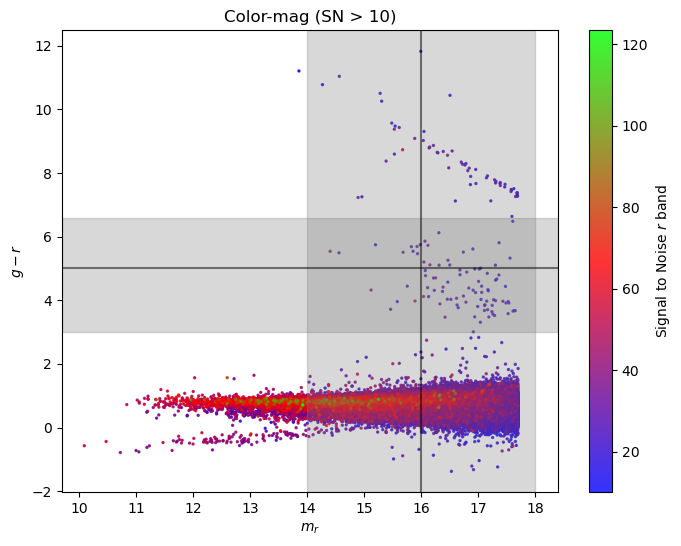

In [16]:
#Region color_5
graficos.color_mag_SN(data_clean_SN10, color, 'r')
plt.title('Color-mag (SN > 10)')

plt.axhline(5, color='black', linestyle='-', alpha=0.5)
plt.axhspan(5 - 2, 5 + 1.6, color='gray', alpha=0.3)
plt.axvline(16, color='black', linestyle='-', alpha=0.5)
plt.axvspan(16 - 2, 16 + 2, color='gray', alpha=0.3)

plt.show()

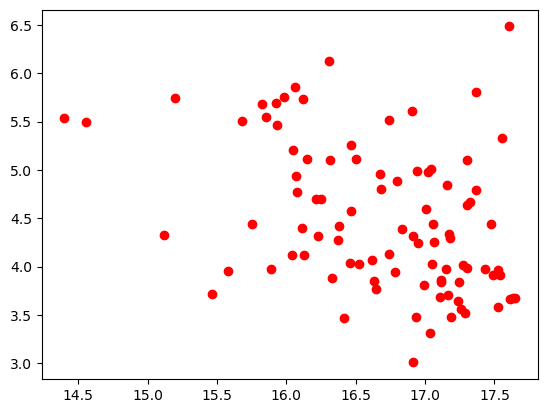

In [17]:
linea_horizontal = 5

y_range = 2 

puntos_color_5 = (color >= linea_horizontal - y_range) & (color <= linea_horizontal + 1.6) & (data_clean_SN10['dered_r']>= 16 - 2) & (data_clean_SN10['dered_r']<= 16 + 2)

#Asignar valor de 3 a la etiqueta de esta zona
data_clean_SN10.loc[puntos_color_5, 'etiqueta'] = 3

plt.scatter(data_clean_SN10['dered_r'][puntos_color_5], color[puntos_color_5], c='red')



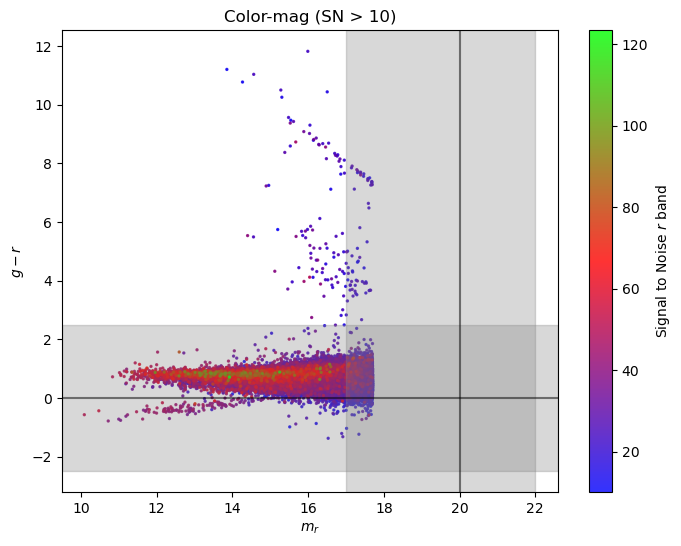

In [18]:
#Region cola
graficos.color_mag_SN(data_clean_SN10, color, 'r')
plt.title('Color-mag (SN > 10)')


plt.axhline(0, color='black', linestyle='-', alpha=0.5)
plt.axhspan(-2.5, 2.5, color='gray', alpha=0.3)
plt.axvline(20, color='black', linestyle='-', alpha=0.5)
plt.axvspan(20 - 3, 20 + 2, color='gray', alpha=0.3)

"""
plt.axhline(0, color='black', linestyle='-', alpha=0.5)
plt.axhspan(-3, 1, color='gray', alpha=0.3)
plt.axvline(23, color='black', linestyle='-', alpha=0.5)
plt.axvspan(23 - 1, 23 + 1 , color='gray', alpha=0.3)
"""
plt.show()

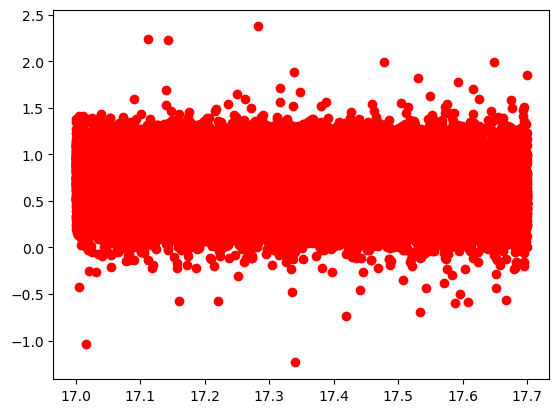

In [19]:
puntos_cola_1 = (color >= -2.5) & (color <= 2.5) & (data_clean_SN10['dered_r']>= 20 - 3) & (data_clean_SN10['dered_r']<= 20 + 2) 
puntos_cola_2 = (color >= -3) & (color <= 1) & (data_clean_SN10['dered_r']>= 23 - 1) & (data_clean_SN10['dered_r']<= 23 + 1)

puntos_cola = puntos_cola_1 | puntos_cola_2

#Asignar valor de 4 a la etiqueta de esta zona
data_clean_SN10.loc[puntos_cola, 'etiqueta'] = 4

plt.scatter(data_clean_SN10['dered_r'][puntos_cola], color[puntos_cola], c='red')



In [20]:
data_clean_SN10['etiqueta'].unique()

array([0, 4, 3, 1])

### Muestreo SN de 20 en 20

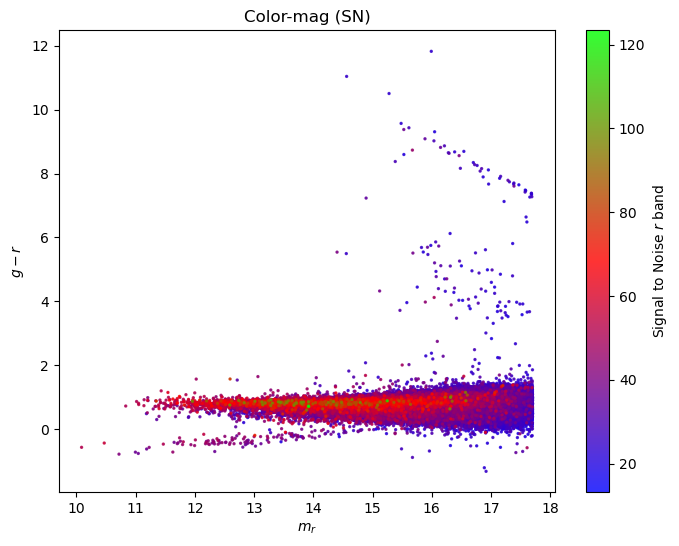

In [21]:
### Datos solo con SN>20 ###
columnas_a_filtrar = ['snMedian_g','snMedian_r']

condicion = pd.Series(False, index=data_clean_SN10.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (data_clean_SN10[columna] > 20)

data_clean_SN20 = data_clean_SN10.loc[condicion]

color = data_clean_SN20['dered_g'] - data_clean_SN20['dered_r']

# Grafico

graficos.color_mag_SN(data_clean_SN20, color, 'r')

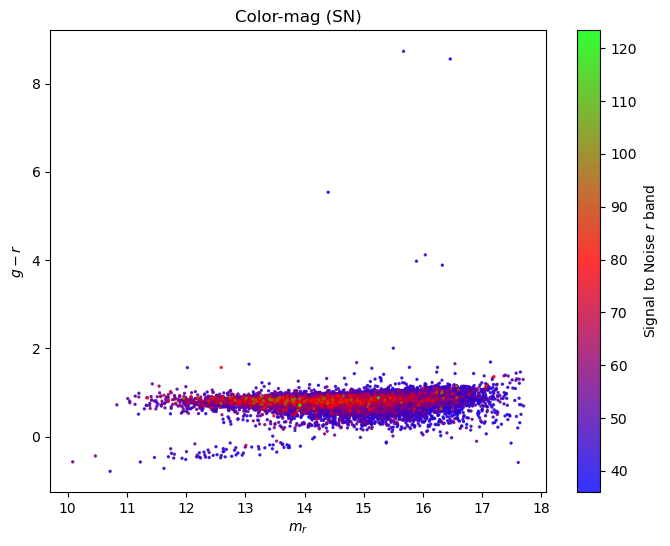

In [22]:
### Datos solo con SN>40 ###
columnas_a_filtrar = ['snMedian_g','snMedian_r']

condicion = pd.Series(False, index=data_clean_SN10.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (data_clean_SN10[columna] > 40)

data_clean_SN40 = data_clean_SN10.loc[condicion]

color = data_clean_SN40['dered_g'] - data_clean_SN40['dered_r']

# Grafico

graficos.color_mag_SN(data_clean_SN40, color, 'r')

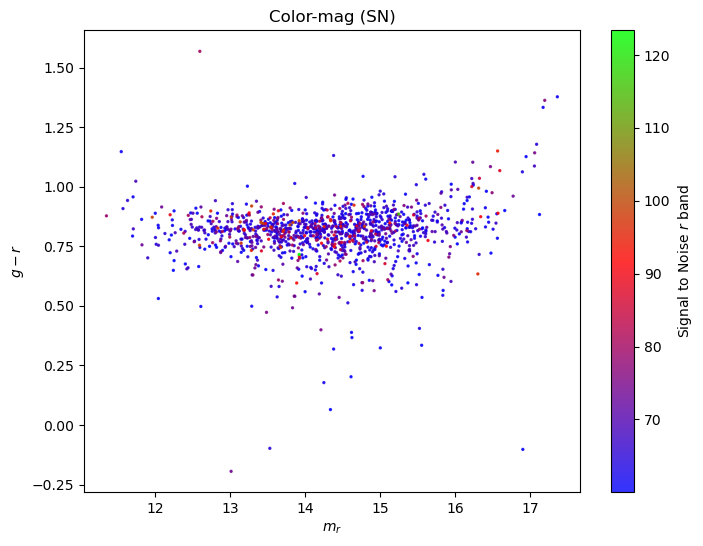

In [23]:
### Datos solo con SN>60 ###
columnas_a_filtrar = ['snMedian_g','snMedian_r']

condicion = pd.Series(False, index=data_clean_SN10.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (data_clean_SN10[columna] > 60)

data_clean_SN60 = data_clean_SN10.loc[condicion]

color = data_clean_SN60['dered_g'] - data_clean_SN60['dered_r']

# Grafico

graficos.color_mag_SN(data_clean_SN60, color, 'r')

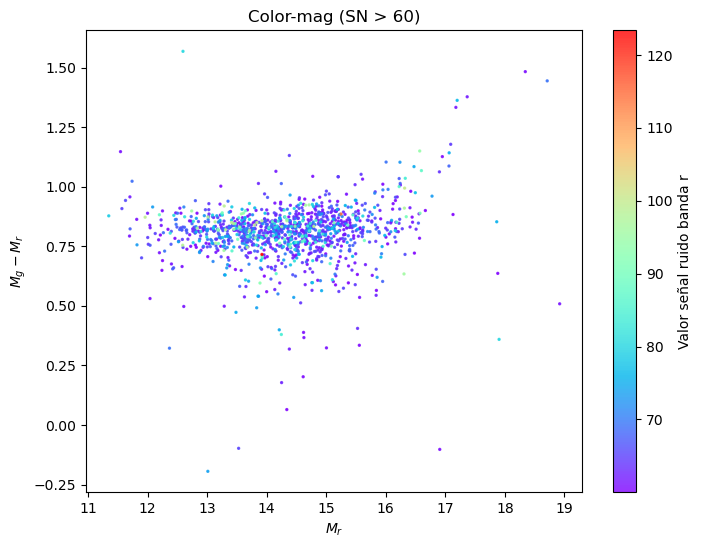

In [24]:
### Datos solo con SN>60 ###
columnas_a_filtrar = ['snMedian_g', 'snMedian_r']

condicion = pd.Series(False, index=datos_SN10.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (datos_SN10[columna] > 60)

data_SN60 = datos_SN10.loc[condicion]

data_clean_SN60 = data_SN60.dropna(subset=['dered_r', 'dered_g', 'snMedian_r'])

y = data_clean_SN60['dered_g'] - data_clean_SN60['dered_r']

#Densidad de puntos basada en snMedian_r
density, _ = np.histogram(data_clean_SN60['snMedian_r'], bins=100, density=True)

#Ordenar los puntos en función de su densidad con respecto a snMedian_r
idx = data_clean_SN60['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN60['dered_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN60['snMedian_r'].values[idx]

plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted, y_sorted, c=snMedian_r_sorted, cmap='rainbow', s=2, alpha=0.8)

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 60)')
plt.show()


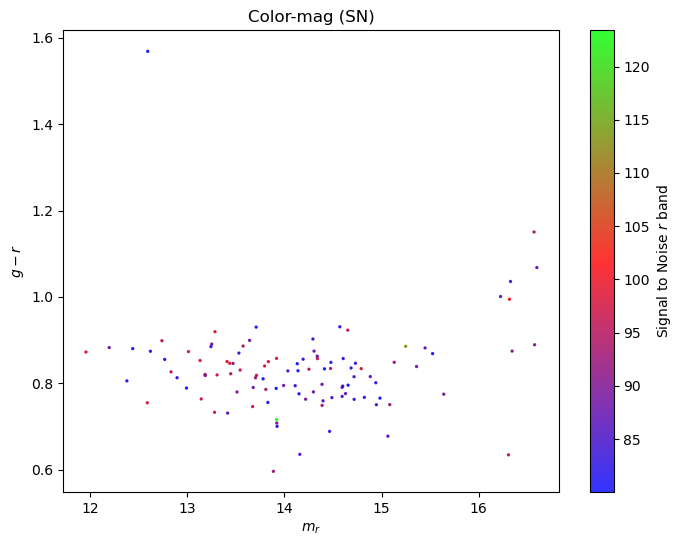

In [25]:
### Datos solo con SN>80 ###
columnas_a_filtrar = ['snMedian_g','snMedian_r']

condicion = pd.Series(False, index=data_clean_SN10.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (data_clean_SN10[columna] > 80)

data_clean_SN80 = data_clean_SN10.loc[condicion]

color = data_clean_SN80['dered_g'] - data_clean_SN80['dered_r']

# Grafico

graficos.color_mag_SN(data_clean_SN80, color, 'r')

# Magnitudes absolutas

### Distancia Comóvil

$r_{i}=c \int_{0}^{z_{i}} \frac{\mathrm{d} z}{H_{0} \sqrt{\Omega_{\mathrm{m}}(1+z)^{3}+\Omega_{\Lambda}}}$

$\Omega_{\mathrm{m}}=0.258$ parámetro de densidad de masa, $H_{0}=72 \mathrm{~km} \mathrm{~s}^{-1} \mathrm{Mpc}^{-1}$ constante de Hubble en el tiempo presente. 

### Magnitud

$M_{x}-5 \log h=m_{x}-D M(z)-K(z)-A_{x}\left(z-z_{n}\right)$

$_x$  para las diferentes bandas $x=$ ( $u, g, r, i, z), M_{x}$ magnitud absoluta, $m_{x}$ magnitud aparente dada por el catálogo, $D M(z)$ módulo de la distancia, $K(z)$ es el término de corrección k, $z_{n}=0.1$ redshift de referencia. Los coeficientes $A_{x}$ cuantifican la corrección por evolución y se toman de Blanton et al. (2003) $A_{x}=$ $(-4.22,-2.04,-1.62,-1.61,-0.76)$ para los cinco colores.

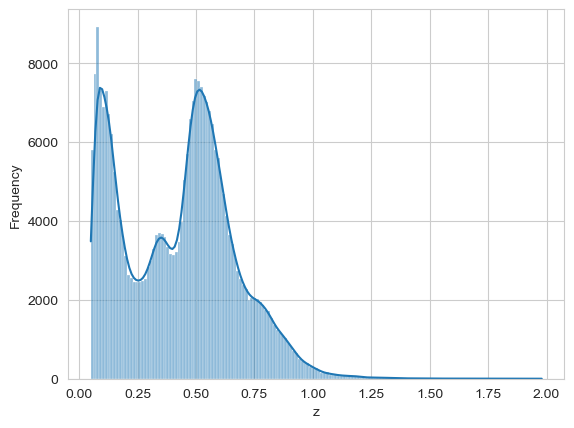

In [21]:
sns.set_style("whitegrid")

sns.histplot(data_clean_SN10['z'], kde=True)

plt.xlabel('z')
plt.ylabel('Frequency')
plt.show()

In [22]:
## Calculo Distancias comoviles con el modulo func ###

data_clean_SN10['r_luminosa'], data_clean_SN10['r_err'] = func.Dist_Lumi(data_clean_SN10['z'], 0, data_clean_SN10['z'] )

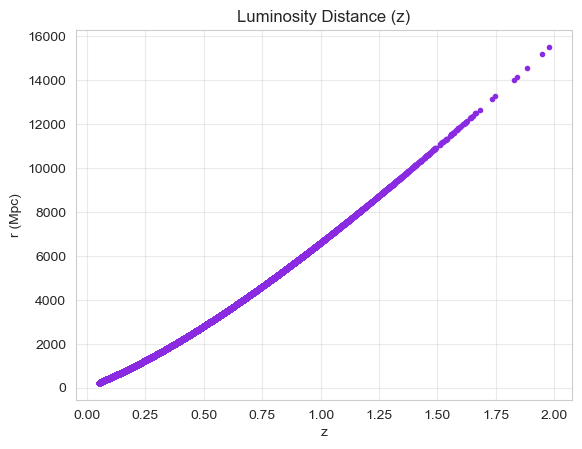

In [23]:
plt.plot( data_clean_SN10['z'], data_clean_SN10['r_luminosa'], '.', color='blueviolet')
plt.xlabel('z')
plt.ylabel('r (Mpc)')
plt.title('Luminosity Distance (z)')
plt.grid(alpha=0.4)

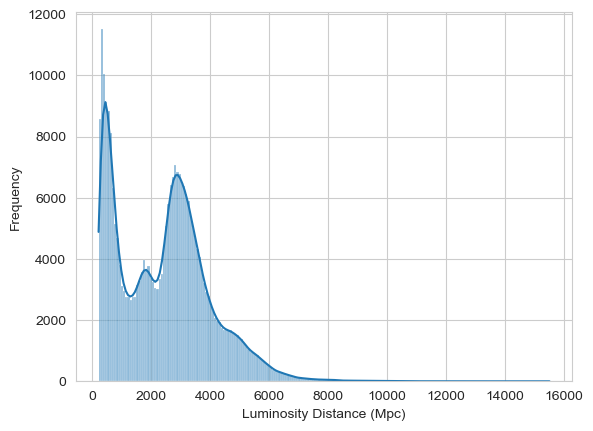

In [24]:
sns.set_style("whitegrid")

sns.histplot(data_clean_SN10['r_luminosa'], kde=True)

plt.xlabel('Luminosity Distance (Mpc)')
plt.ylabel('Frequency')
plt.show()

In [25]:
## Calculo Modulo de la distancia con el modulo func ###

data_clean_SN10['DM'] = 0

for i in data_clean_SN10.index:
    data_clean_SN10['DM'][i] = func.DistanceModulus(data_clean_SN10['r_luminosa'][i])
    

In [26]:
### Calculo de Magnitudes Absolutas con el modulo func ###

h =0.7 

data_clean_SN10['M_r'] = 0
data_clean_SN10['M_g'] = 0

for i in data_clean_SN10.index:
    data_clean_SN10['M_r'][i] = func.M_x(data_clean_SN10['dered_r'][i], data_clean_SN10['DM'][i], 0, 0, data_clean_SN10['z'][i] )
    data_clean_SN10['M_g'][i] = func.M_x(data_clean_SN10['dered_g'][i], data_clean_SN10['DM'][i], 0, 0, data_clean_SN10['z'][i] )

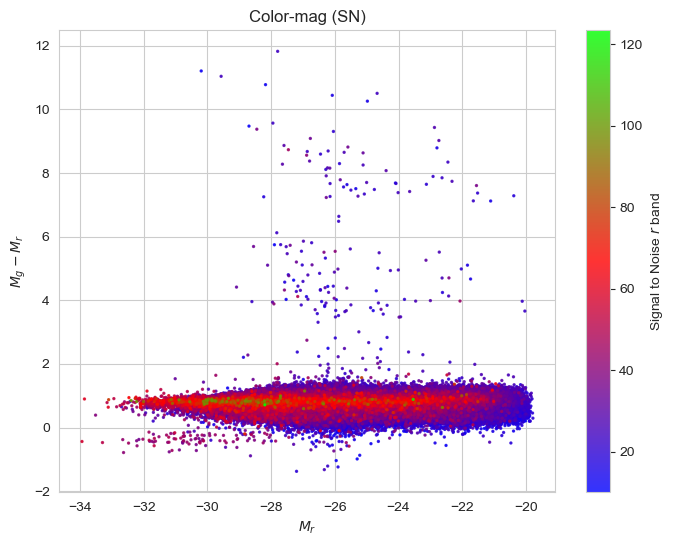

In [27]:
## Asignacion y graficacion ###

M_r = data_clean_SN10['M_r']
M_g = data_clean_SN10['M_g']

m_r =  data_clean_SN10['dered_r']
m_g =  data_clean_SN10['dered_g']

color = m_g - m_r

## Respecto a SN
graficos.color_Mag_SN(data_clean_SN10, color, 'r')


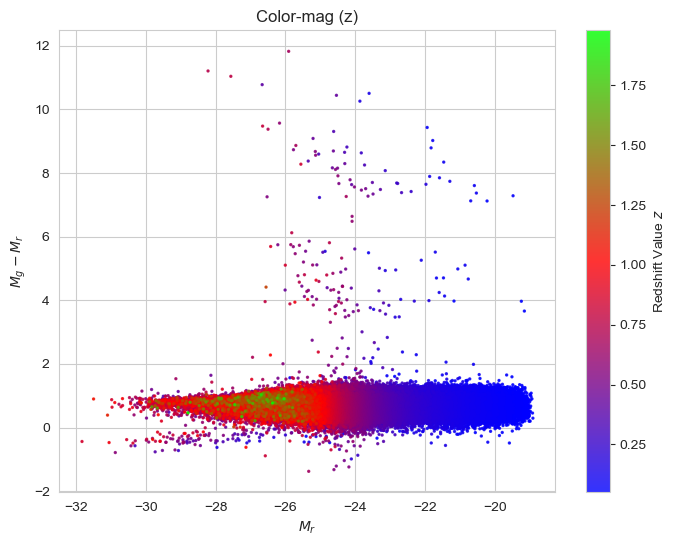

In [33]:
#Respecto a z

graficos.color_Mag_z(data_clean_SN10, color, 'r')

6         -23.495861
9         -25.294430
44        -27.947065
52        -27.184404
82        -25.745931
             ...    
2617687   -24.414835
2617704   -20.903815
2617771   -26.648823
2617772   -27.574291
2617777   -23.587141
Name: M_r, Length: 288931, dtype: float64

Text(0.5, 1.0, 'Magnitude (z)')

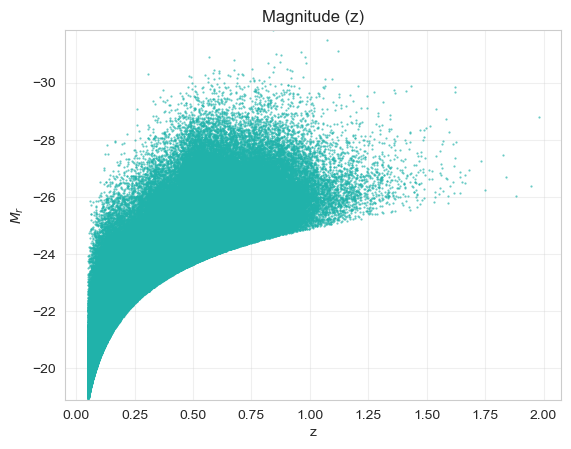

In [34]:
plt.scatter(data_clean_SN10['z'], M_r, color='lightseagreen', alpha =0.7, s=0.3)
plt.grid(alpha=0.3)
plt.xlabel('z')
plt.ylabel('$M_r$')
plt.ylim(max(M_r), min(M_r))
plt.title('Magnitude (z)')

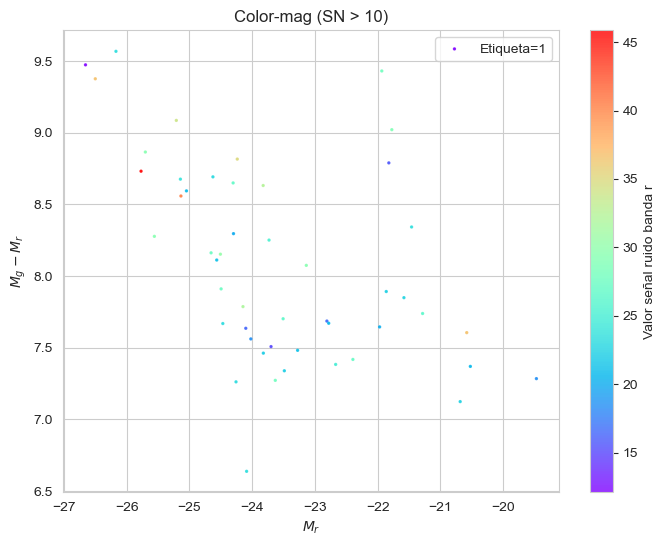

In [35]:
### Las de etiqueta 1###

y = color
density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN10['M_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 1], y_sorted[etiqueta_sorted == 1], c=snMedian_r_sorted[etiqueta_sorted == 1], cmap='rainbow', s=2, alpha=0.8, label='Etiqueta=1')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.legend()
plt.show()


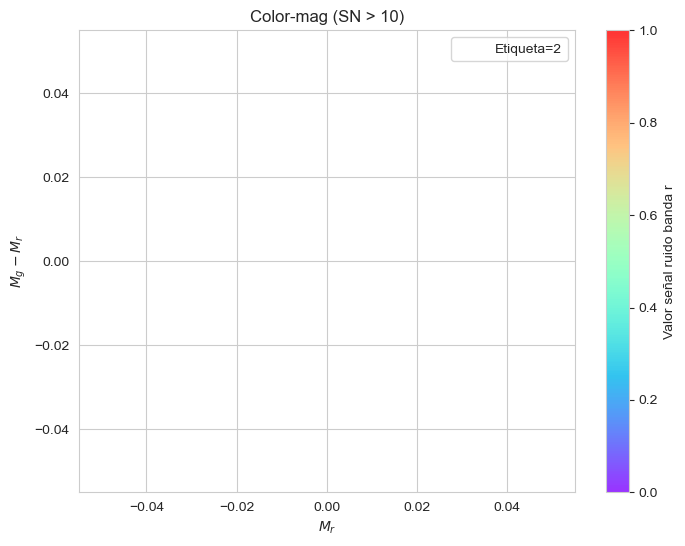

In [36]:
### Las de etiqueta 2 ###

y = color

density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN10['M_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 2], y_sorted[etiqueta_sorted == 2], c=snMedian_r_sorted[etiqueta_sorted == 2], cmap='rainbow', s=2, alpha=0.8, label='Etiqueta=2')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.legend()
plt.show()

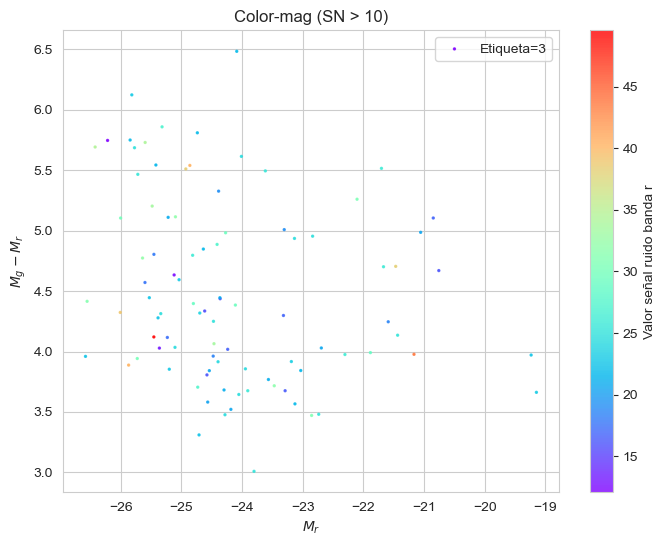

In [37]:
### Las de etiqueta 3 ###

y = color

density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN10['M_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 3], y_sorted[etiqueta_sorted == 3], c=snMedian_r_sorted[etiqueta_sorted == 3], cmap='rainbow', s=2, alpha=0.8, label='Etiqueta=3')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.legend()
plt.show()

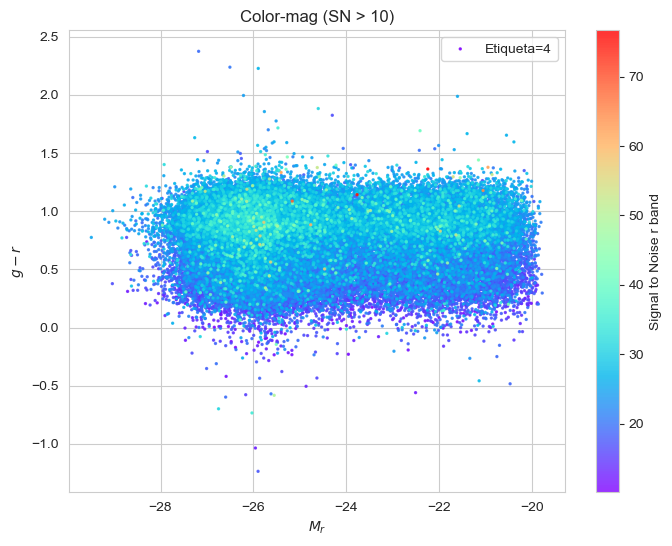

In [29]:
### Las de etiqueta 4 ###

y = color

density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN10['M_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 4], y_sorted[etiqueta_sorted == 4], c=snMedian_r_sorted[etiqueta_sorted == 4], cmap='rainbow', s=2, alpha=0.8, label='Etiqueta=4')

plt.colorbar(label='Signal to Noise r band')  
plt.xlabel('$M_r$ ')
plt.ylabel('$g - r$')
plt.title('Color-mag (SN > 10)')
plt.legend()
plt.show()

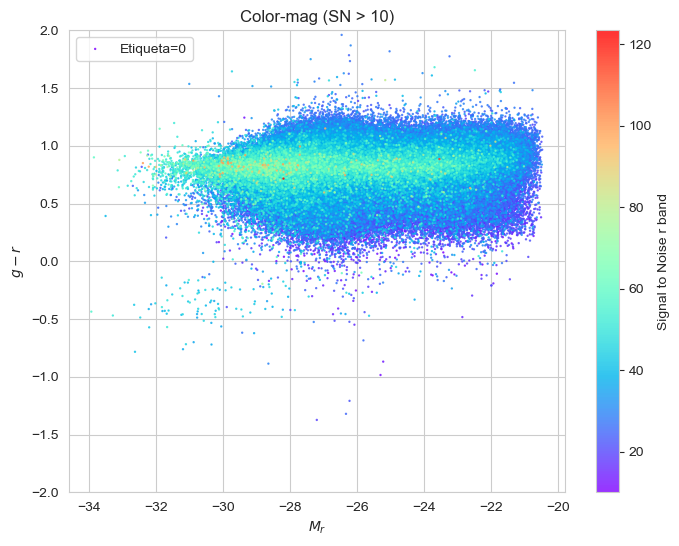

In [30]:
### Las de etiqueta 0 ###

y = color

density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN10['M_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 0], y_sorted[etiqueta_sorted == 0], c=snMedian_r_sorted[etiqueta_sorted == 0], cmap='rainbow', s=0.5, alpha=0.8, label='Etiqueta=0')

plt.colorbar(label='Signal to Noise r band')  
plt.xlabel('$M_r$ ')
plt.ylabel('$g - r$')
plt.title('Color-mag (SN > 10)')
plt.ylim(-2, 2)
plt.legend()
plt.show()

## Kcorrect y EC

$A_x = (−4.22, −2.04, −1.62, −1.61, −0.76)$
(u, g, r, i, z)

In [40]:
def EC(A, z, zn):
    return A*(z- zn)

In [ ]:
responses = ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']
kc = kcorrect.kcorrect.Kcorrect(responses=responses)
A = np.array([-4.22, -2.04, -1.62, -1.61, -0.76])

#Redshift
redshift = data_clean_SN10['z'].to_numpy()

#Fluxes and fluxes Inverse variance
petroFlux_columns = ['petroFlux_u', 'petroFlux_g', 'petroFlux_r', 'petroFlux_i', 'petroFlux_z']
petroFluxIvar_columns = ['petroFluxIvar_u', 'petroFluxIvar_g', 'petroFluxIvar_r', 'petroFluxIvar_i', 'petroFluxIvar_z']

maggies = data_clean_SN10[petroFlux_columns].to_numpy()

ivar = data_clean_SN10[petroFluxIvar_columns].to_numpy()


coeffs = kc.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)

#K-corrections in magnitude units
k = kc.kcorrect(redshift=redshift, coeffs=coeffs)

absmag = kc.absmag(redshift=redshift, maggies=maggies, ivar=ivar, coeffs=coeffs)

In [42]:
data_clean_SN10['M_r_kcorrect'] = absmag[:,2]
data_clean_SN10['M_g_kcorrect'] = absmag[:,1]

data_clean_SN10['kcorrect_r'] = k[:,2]
data_clean_SN10['kcorrect_g'] = k[:,1]

In [43]:
y = data_clean_SN10['M_g_kcorrect'] - data_clean_SN10['M_r_kcorrect']

data_clean_SN10['M_r_kcorrect'], y

(6         -41.912010
 9         -45.468376
 44        -46.132458
 52        -48.658325
 82        -46.431900
              ...    
 2617687   -41.417374
 2617704   -40.549763
 2617771   -47.518444
 2617772   -46.598301
 2617777   -38.408802
 Name: M_r_kcorrect, Length: 288931, dtype: float32,
 6             0.386730
 9             1.081257
 44            1.336990
 52            0.410290
 82           -0.004524
               ...     
 2617687   -9957.583008
 2617704       1.362637
 2617771       1.159477
 2617772       0.763084
 2617777       0.418194
 Length: 288931, dtype: float32)

(-50.0, 50.0)

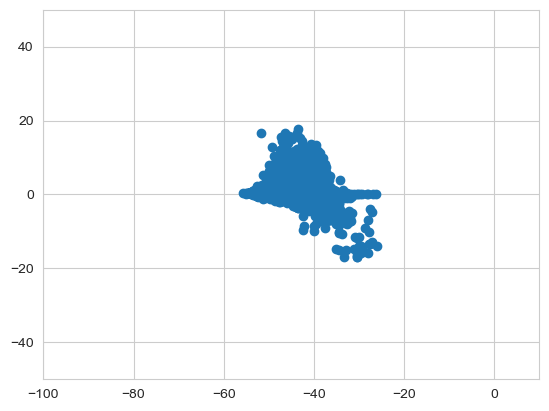

In [ ]:
plt.scatter(data_clean_SN10['M_r_kcorrect'], y)
plt.xlim(-100,10)
plt.ylim(-50,50)

In [45]:
data_clean_SN10['kcorrect_r'] 

6          0.148268
9          0.813290
44         1.126318
52         0.537323
82        -0.201036
             ...   
2617687    0.973812
2617704    0.137557
2617771    0.905203
2617772    0.894182
2617777    0.191218
Name: kcorrect_r, Length: 288931, dtype: float32

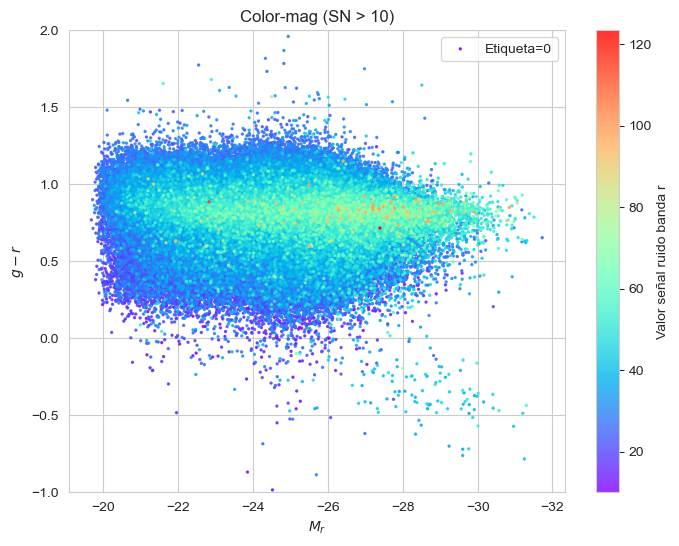

In [ ]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las de etiqueta 0 ###
zn = 0.1

corr_r =  data_clean_SN10['kcorrect_r'] 
 
corr_g = data_clean_SN10['kcorrect_g']

#Nuevas magnitudes
M_g_corr = M_g - corr_g - EC(A[1], data_clean_SN10['z'], zn )

M_r_corr = M_r - corr_r - EC(A[2], data_clean_SN10['z'], zn )

color_gr = m_g - m_r


### Grafico ####
density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 0], y_sorted[etiqueta_sorted == 0], c=snMedian_r_sorted[etiqueta_sorted == 0], cmap='rainbow', s=2, alpha=0.8, label='Etiqueta=0')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$g - r$')
plt.title('Color-mag (SN > 10)')
plt.ylim(-1,2)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

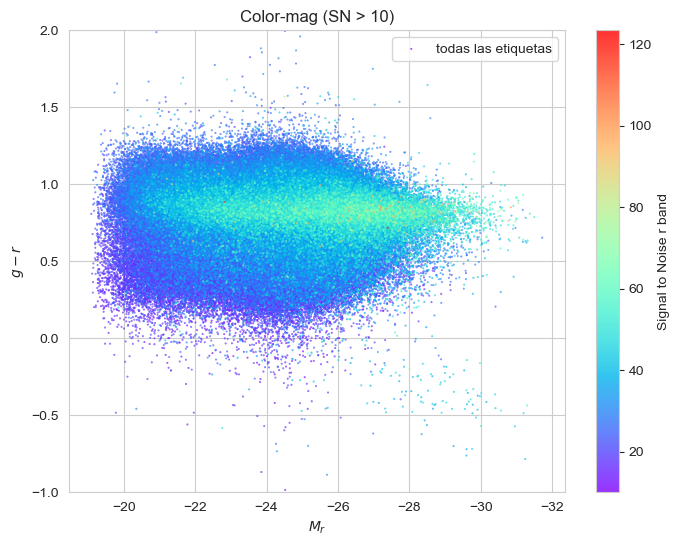

In [ ]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las todas las etiquetas ###

### Grafico ####
density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted, y_sorted, c=snMedian_r_sorted, cmap='rainbow', s=0.2, alpha=0.8, label='todas las etiquetas')

plt.colorbar(label='Signal to Noise r band')  
plt.xlabel('$M_r$ ')
plt.ylabel('$g - r$')
plt.title('Color-mag (SN > 10)')
plt.ylim(-1,2)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

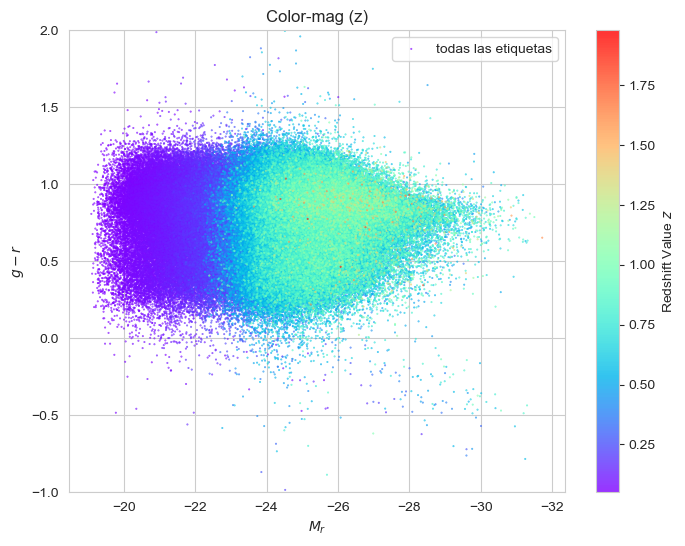

In [ ]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las todas las etiquetas ###

### Grafico ####
density, _ = np.histogram(data_clean_SN10['z'], bins=100, density=True)

idx = data_clean_SN10['z'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
redshift_sorted = data_clean_SN10['z'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted, y_sorted, c=redshift_sorted, cmap='rainbow', s=0.2, alpha=0.8, label='todas las etiquetas')

plt.colorbar(label='Redshift Value $z$')  
plt.xlabel('$M_r$ ')
plt.ylabel('$g - r$')
plt.title('Color-mag (z)')
plt.ylim(-1,2)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

#### Para los flujos modelFlux:

In [ ]:
#Fluxes and fluxes Inverse variance
modelFlux_columns = ['modelFlux_u', 'modelFlux_g', 'modelFlux_r', 'modelFlux_i', 'modelFlux_z']
modelFluxIvar_columns = ['modelFluxIvar_u', 'modelFluxIvar_g', 'modelFluxIvar_r', 'modelFluxIvar_i', 'modelFluxIvar_z']

maggies = data_clean_SN10[modelFlux_columns].to_numpy()

ivar = data_clean_SN10[modelFluxIvar_columns].to_numpy()

coeffs = kc.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)

#K-corrections in magnitude units
k = kc.kcorrect(redshift=redshift, coeffs=coeffs)

absmag = kc.absmag(redshift=redshift, maggies=maggies, ivar=ivar, coeffs=coeffs)


### Nuevas columnas ###

data_clean_SN10['M_r_kcorrect_modelFlux'] = absmag[:,2]
data_clean_SN10['M_g_kcorrect_modelFlux'] = absmag[:,1]

data_clean_SN10['kcorrect_r_modelFlux'] = k[:,2]
data_clean_SN10['kcorrect_g_modelFlux'] = k[:,1]


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


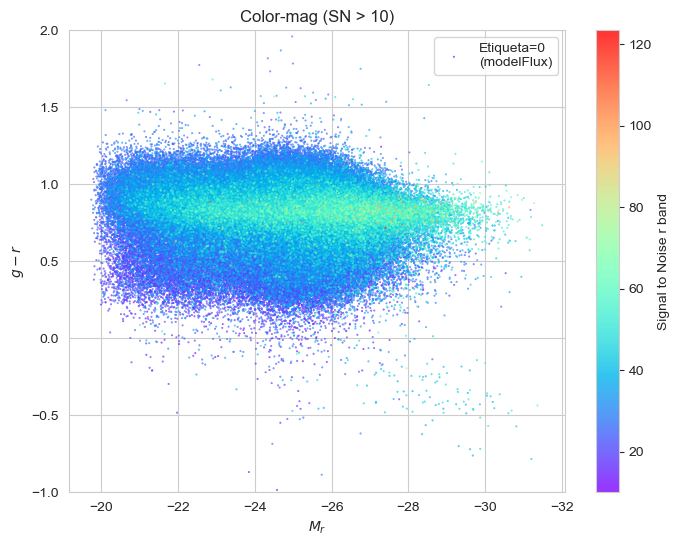

In [50]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las de etiqueta 0 ###

corr_r =  data_clean_SN10['kcorrect_r_modelFlux'] 
 
corr_g = data_clean_SN10['kcorrect_g_modelFlux']

#Nuevas magnitudes
M_g_corr = M_g - corr_g - EC(A[1], data_clean_SN10['z'], zn )# #

M_r_corr = M_r - corr_r - EC(A[2], data_clean_SN10['z'], zn ) # #

color_gr = color


### Grafico ####
density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 0], y_sorted[etiqueta_sorted == 0], c=snMedian_r_sorted[etiqueta_sorted == 0], cmap='rainbow', s=0.2, alpha=0.8, label='Etiqueta=0\n(modelFlux)')

plt.colorbar(label='Signal to Noise r band')  
plt.xlabel('$M_r$ ')
plt.ylabel('$g - r$')
plt.title('Color-mag (SN > 10)')
plt.ylim(-1,2)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


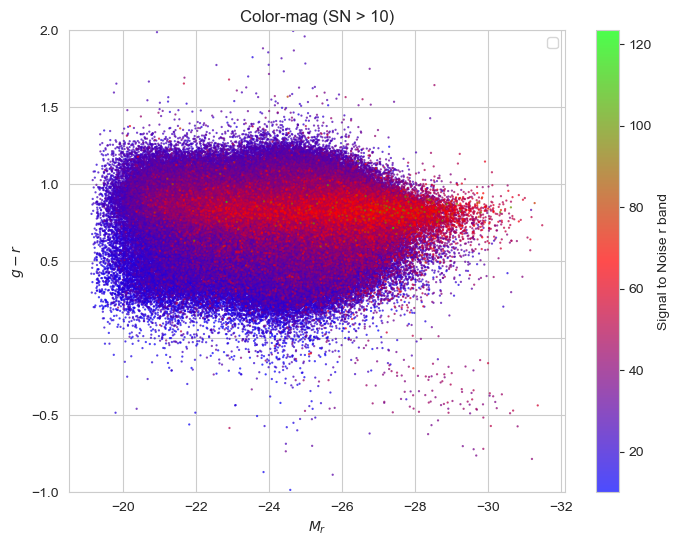

In [ ]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las todas las etiquetas ###

### Grafico ####
density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted, y_sorted, c=snMedian_r_sorted, cmap='brg', s=0.4, alpha=0.7)

plt.colorbar(label='Signal to Noise r band')  
plt.xlabel('$M_r$ ')
plt.ylabel('$g-r$')
plt.title('Color-mag (SN > 10)')
plt.ylim(-1,2)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [52]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las todas las etiquetas ###

### Grafico ####
density, _ = np.histogram(data_clean_SN10['z'], bins=100, density=True)

idx = data_clean_SN10['z'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
redshift_sorted = data_clean_SN10['z'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted, y_sorted, c=redshift_sorted, cmap='rainbow', s=0.2, alpha=0.8)

plt.colorbar(label='Redshift Value z')  
plt.xlabel('$M_r$ ')
plt.ylabel('$g - r$')
plt.title('Color-mag (z)')
plt.ylim(-3,3)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

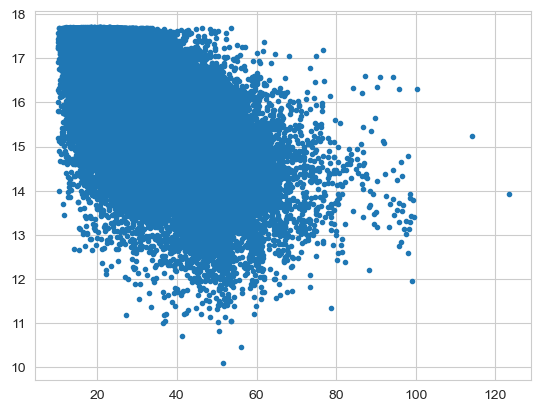

In [53]:
plt.plot(data_clean_SN10['snMedian_r'], data_clean_SN10['dered_r'], '.')

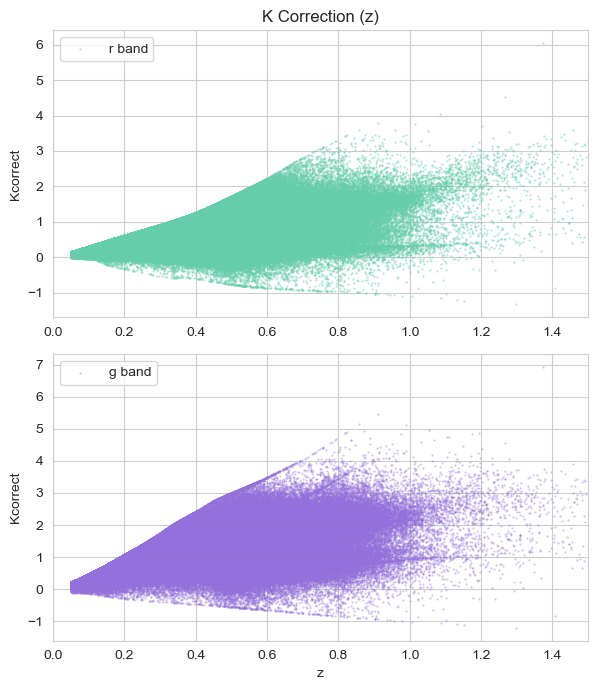

In [54]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7))


axs[0].scatter(data_clean_SN10['z'], corr_r, s=0.3, alpha=0.5, label=' r band', color='#66cdaa')
axs[0].set_ylabel('Kcorrect')
axs[0].set_title('K Correction (z)')
axs[0].set_xlim(0, 1.50)
axs[0].legend()

axs[1].scatter(data_clean_SN10['z'], corr_g, s=0.2, alpha=0.5, label=' g band', color='#9370db')
axs[1].set_xlabel('z')
axs[1].set_ylabel('Kcorrect')
axs[1].set_xlim(0, 1.50)
axs[1].legend()


plt.tight_layout()
plt.show()

### corte etiquetas

In [55]:
condicion_etiqueta = condicion | ((data_clean_SN10['etiqueta'] == 0) | (data_clean_SN10['etiqueta'] == 4))

data_clean_SN10 = data_clean_SN10.loc[condicion_etiqueta]


(array([1.30000e+01, 2.82000e+02, 2.01000e+03, 1.22100e+04, 5.74050e+04,
        1.05576e+05, 4.72500e+04, 3.46360e+04, 2.41630e+04, 5.24500e+03]),
 array([-11.95994843, -10.67270062,  -9.38545281,  -8.09820501,
         -6.8109572 ,  -5.5237094 ,  -4.23646159,  -2.94921379,
         -1.66196598,  -0.37471817,   0.91252963]),
 <BarContainer object of 10 artists>)

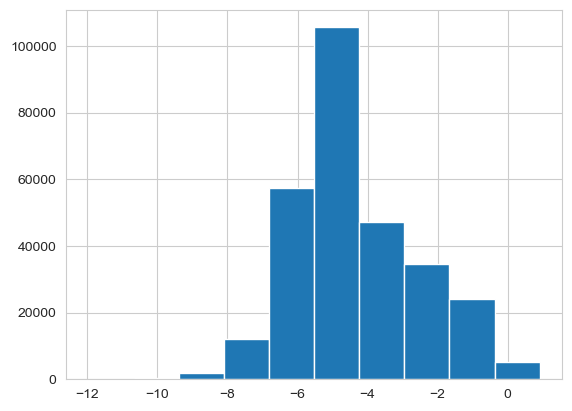

In [56]:
plt.hist(data_clean_SN10['M_r']- EC(A[2], data_clean_SN10['z'], zn ))#data_clean_SN10['kcorrect_r_modelFlux'])

In [55]:
data_clean_SN10.to_csv('data_clean_SN10.csv', index=False)